# Finding Root Causes of Changes in a Supply Chain

In a supply chain, the number of units of each product in the inventory that is available for shipment is crucial to fulfill customers' demand faster. For this reason, retailers continuously buy products anticipating customers' demand in the future.

Suppose that each week a retailer submits purchase orders (POs) to vendors taking into account future demands for products and capacity constraints to consider for demands. The vendors will then confirm whether they can fulfill some or all of the retailer's purchase orders. Once confirmed by the vendors and agreed by the retailer, products are then sent to the retailer. All of the confirmed POs, however, may not arrive at once.

<img src="./images/supply-chain.png" width="800"/>

## Week-over-week changes

For this case study, we consider synthetic data inspired from a real-world use case in supply chain. Let us look at data over two weeks, *w1* and *w2* in particular.

In [1]:
import pandas as pd

data = pd.read_csv('supply_chain_week_over_week.csv')

In [2]:
from IPython.display import HTML

data_week1 = data[data.week == 'w1']

HTML(data_week1.head().to_html(index=False)+'<br/>')

asin,demand,constraint,submitted,confirmed,received,week
C33384370E,5.0,2.0,5.0,5.0,5.0,w1
F48C534AEF,1.0,0.0,2.0,2.0,2.0,w1
6DF2CA5FB8,4.0,2.0,2.0,2.0,2.0,w1
1D1C2500DB,2.0,1.0,2.0,2.0,2.0,w1
0A83B415E2,0.0,1.0,-0.0,-0.0,-0.0,w1


In [3]:
data_week2 = data[data.week=='w2']

HTML(data_week2.head().to_html(index=False)+'<br/>')

asin,demand,constraint,submitted,confirmed,received,week
C33384370E,3.0,1.0,3.0,7.0,7.0,w2
F48C534AEF,3.0,2.0,1.0,3.0,3.0,w2
6DF2CA5FB8,5.0,1.0,6.0,12.0,12.0,w2
1D1C2500DB,3.0,3.0,0.0,1.0,1.0,w2
0A83B415E2,3.0,1.0,2.0,5.0,5.0,w2


Our target of interest is the average value of *received* over those two weeks.

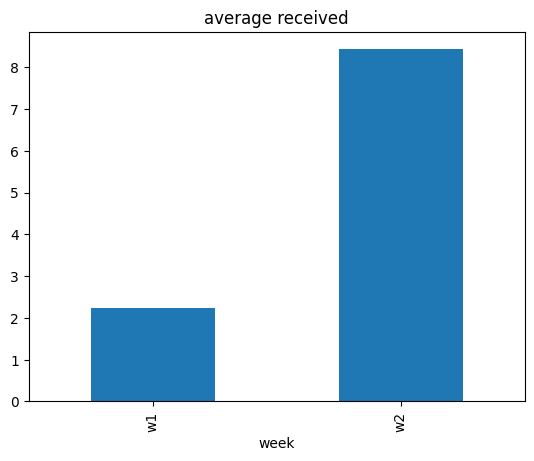

In [4]:
data.groupby(['week']).mean(numeric_only=True)[['received']].plot(kind='bar', title='average received', legend=False);

In [5]:
data_week2.received.mean() - data_week1.received.mean()

6.197

The average value of *received* quantity has increased from week *w1* to week *w2*. Why?

## Why did the average value of `received` quantity change week-over-week?

### Ad-hoc attribution analysis

To answer the question, one option is to look at the average value of other variables week-over-week, and see if there are any associations.

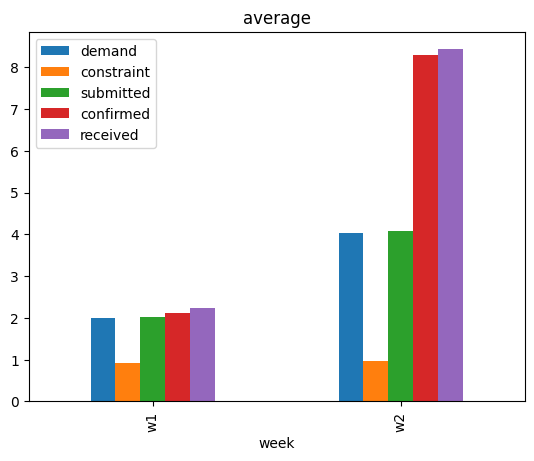

In [6]:
data.groupby(['week']).mean(numeric_only=True).plot(kind='bar', title='average', legend=True);

We see that the average values of other variables, except *constraint*, have also increased. While this suggests that some event(s) that changed the average values of other variables could possibly have changed the average value of *received*, that on itself is not a satisfactory answer. One may also use domain knowledge here to claim that change in the average value of demand could be the main driver, after all demand is a key variable. We will see later that such conclusions can miss other important factors. For a rather systematic answer, we turn to attribution analysis based on causality.

### Causal Attribution Analysis

We consider the distribution-change-attribution method based on graphical causal models described in [Budhathoki et al., 2021](https://arxiv.org/abs/2102.13384), which is also implmented in *Causality*. In summary, given the underlying causal graph of variables, the attribution method attributes the change in the marginal distribution of a target variable (or its summary, such as its mean) to changes in data-generating processes (also called "causal mechanisms") of variables upstream in the causal graph. A causal mechanism of a variable is the conditional distribution of the variable given its *direct causes*. We can also think of a causal mechanism as an algorithm (or a compute program) in the system that takes the values of direct causes as input and produces the value of the effect as an output. To use the attribution method, we first require the causal graph of the variables, namely *demand*, *constraint*, *submitted*, *confirmed* and *received*.

#### Graphical causal model

We build the causal graph using domain knowledge. Based on the description of supply chain in the introduction, it is plausible to assume the following causal graph. 

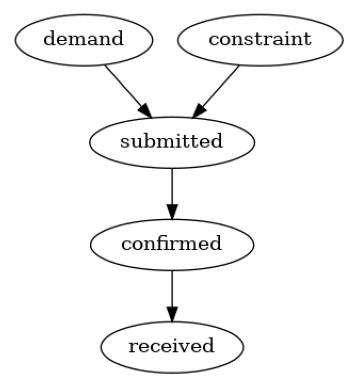

In [7]:
import networkx as nx
import dowhy.gcm as gcm
from dowhy.utils import plot

causal_graph = nx.DiGraph([('demand', 'submitted'),
                           ('constraint', 'submitted'),
                           ('submitted', 'confirmed'), 
                           ('confirmed', 'received')])
plot(causal_graph)

#### Attributing change

We can now attribute the week-over-week change in the average value of *received* quantity using *Causality*. 

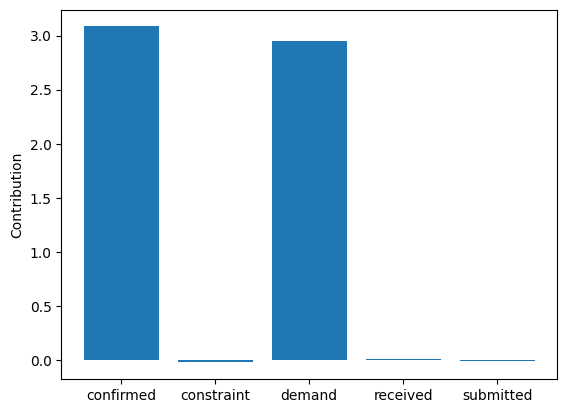

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# disabling progress bar to not clutter the output here
gcm.config.disable_progress_bars()

# setting random seed for reproducibility
np.random.seed(10)

causal_model = gcm.StructuralCausalModel(causal_graph)

# Automatically assign appropriate causal models to each node in graph
gcm.auto.assign_causal_mechanisms(causal_model, data_week1)

# call the API for attributing change in the average value of `received`
contributions = gcm.distribution_change(causal_model,
                                        data_week1, 
                                        data_week2, 
                                        'received', 
                                        num_samples=2000,
                                        difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1))

plt.bar(contributions.keys(), contributions.values())
plt.ylabel('Contribution')
plt.show()

These point estimates suggest that changes in the causal mechanisms of *demand* and *confirmed* are the main drivers of the change in the average value of *received* between two weeks. It would be risky, however, to draw conclusions from these point estimates. Therefore, we compute the bootstrap confidence interval for each attribution.

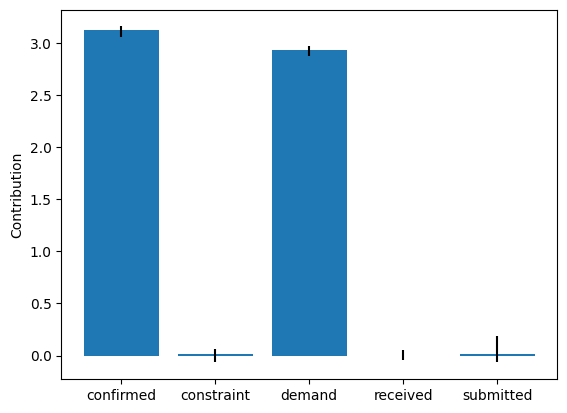

In [9]:
median_contribs, uncertainty_contribs = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.distribution_change,
                           causal_model,
                           data_week1, 
                           data_week2, 
                           'received', 
                           num_samples=2000,
                           difference_estimation_func=lambda x1, x2 : np.mean(x2) - np.mean(x1)), 
    confidence_level=0.95, 
    num_bootstrap_resamples=10)

yerr_plus = [uncertainty_contribs[node][1] - median_contribs[node] for node in median_contribs.keys()]
yerr_minus = [median_contribs[node] - uncertainty_contribs[node][0] for node in median_contribs.keys()]
plt.bar(median_contribs.keys(), median_contribs.values(), yerr=np.array([yerr_minus, yerr_plus]), ecolor='black')
plt.ylabel('Contribution')
plt.show()

Whereas the $95\%$ confidence intervals for the contributions of *demand* and *confirmed* are above $0$, those of other nodes are close to $0$.
Overall, these results suggest that changes in the causal mechanisms of *demand* and *confirmed* are the drivers for the observed change in the *received* quantity week-over-week. Causal mechanisms can change in a real-world system, for instance, after deploying a new subsystem with a different algorithm. In fact, these results are consistent with the **ground truth** (see Appendix).

## Appendix: Ground Truth

We generate synthetic data inspired from a real-world use case in Amazon's supply chain. To this end, we assume a linear Additive Noise Model (ANM) as the underlying data-generating process at each node. That is, each node is a linear function of its direct causes and an additive unobserved noise term. For more technical details on ANMs, we refer the interested reader to Chapter 7.1.2 of [Elements of Causal Inference book](https://library.oapen.org/bitstream/handle/20.500.12657/26040/11283.pdf?sequence=1&isAllowed=y). Using linear ANMs, we generate data (or draw i.i.d. samples) from the distribution of each variable. We use the Gamma distribution for noise terms mainly to mimic real-world setting, where the distribution of variables often show heavy-tail behaviour. Between two weeks, we only change the data-generating process (causal mechanism) of *demand* and *confirmed* respectively by changing the value of demand mean from $2$ to $4$, and  linear coefficient $\alpha$ from $1$ to $2$.

In [10]:
import pandas as pd
import secrets

ASINS = [secrets.token_hex(5).upper() for i in range(1000)]
import numpy as np
def buying_data(alpha, beta, demand_mean):
    constraint = np.random.gamma(1, scale=1, size=1000)
    demand = np.random.gamma(demand_mean, scale=1, size=1000)
    submitted = demand - constraint + np.random.gamma(1, scale=1, size=1000)
    confirmed = alpha * submitted + np.random.gamma(0.1, scale=1, size=1000)
    received = beta * confirmed + np.random.gamma(0.1, scale=1, size=1000)
    return pd.DataFrame(dict(asin=ASINS,
                              demand=np.round(demand),
                              constraint=np.round(constraint),
                              submitted = np.round(submitted), 
                              confirmed = np.round(confirmed), 
                              received = np.round(received)))


# we change the parameters alpha and demand_mean between weeks
data_week1 = buying_data(1, 1, demand_mean=2)
data_week1['week'] = 'w1'
data_week2 = buying_data(2, 1, demand_mean=4)
data_week2['week'] = 'w2'

data = pd.concat([data_week1, data_week2], ignore_index=True)
# write data to a csv file
# data.to_csv('supply_chain_week_over_week.csv', index=False)